# Solving MDP basics with Value iteration

In [1]:
import numpy as np
np.set_printoptions(precision=2)
import matplotlib.pylab as plt

In [2]:
# indexing of state space ???

class MDP_state_space_1d_grid:
    # we assume there is no stage reward, just "next state reward"
    # also assume stationarity
    # assume single-variate decision
    def __init__(self, reward_table):
        """a stationary MDP with both the state and action space being 1D discrete.
        num_states to be inferred from the reward table
        """
        assert reward_table.ndim == 1
        self.reward_table = reward_table
        self.is_done = False
    def get_num_states(self):
        return len(self.reward_table)
    def state_idx_is_valid(self, state_idx):
        return state_idx in range(0, self.get_num_states())
        
    def get_admissible_action(self, state_idx):
        """
        action denotes the "desired" next state
        """
        assert self.state_idx_is_valid(state_idx)
        possible_set = [0]
        if state_idx < self.get_num_states()-1 :
            possible_set.append(+1)
        if state_idx > 0:
            possible_set.append(-1)
        return possible_set
    
    def get_pmf_next_state_given_action(self, state_idx, action):
        next_state_pmf_table = np.zeros([self.get_num_states()],dtype=float)
        # I assume the action is feasible!
        #
        # hard coding!
        if action == 0:
            if state_idx == 0:
                next_state_pmf_table[state_idx+1] = 0.1
                next_state_pmf_table[state_idx]   = 0.9
            elif state_idx == self.get_num_states()-1:
                next_state_pmf_table[state_idx-1] = 0.1
                next_state_pmf_table[state_idx]   = 0.9
            else:
                next_state_pmf_table[state_idx+1] = 0.05
                next_state_pmf_table[state_idx-1] = 0.05
                next_state_pmf_table[state_idx]   = 0.90
        elif action in (1, -1): 
            next_state_pmf_table[state_idx] = 0.2
            next_state_pmf_table[state_idx+action] = 0.8            
        return next_state_pmf_table
    
    def reward(self, state_idx):
        assert self.state_idx_is_valid(state_idx)
        return self.reward_table[state_idx]
    
    def calc_value(self, gamma = 0.8, N_iter = 100, verbose = False):
        assert isinstance(N_iter,int) and N_iter > 0
        assert 0.0 <= gamma < 1, "the discount factor must be in [0, 1)"
        self.val_table = np.zeros((N_iter+1,self.get_num_states()), dtype=float)
        for i in range(1, N_iter+1):
            if verbose:
                print("i: ", f"{i}".rjust(6), end=': ')
            val_table_old = self.val_table[i-1,:]
            for state_idx in range(0, self.get_num_states()):
                action_set = self.get_admissible_action(state_idx)
                max_expected_utility = -np.inf
                for action in action_set:
                    next_state_pmf = self.get_pmf_next_state_given_action(state_idx, action)
                    expected_utility = np.sum(next_state_pmf*val_table_old)
                    if expected_utility > max_expected_utility:
                        max_expected_utility = expected_utility
                #-----------------------
                self.val_table[i, state_idx] = self.reward_table[state_idx] + gamma* max_expected_utility
            if verbose:
                print(self.val_table[i])
        self.is_done = True
    
    def calc_traj(self, initial_state_idx, sim_steps, seed=34234):
        """actually solve the MDP
        using the value table!
        """
        from numpy.random import default_rng
        rng = default_rng(seed)
        
        assert self.is_done
        assert self.state_idx_is_valid(initial_state_idx)
        assert isinstance(sim_steps,int) and sim_steps > 0
        # input trajectory 
        U = np.zeros((sim_steps),dtype=int)
        # state trajectory
        X = np.ones((sim_steps+1),dtype = int)
        X[0] = initial_state_idx
        
        val_table = self.val_table[-1,:]
        for t in range(0,sim_steps):
            action_set = self.get_admissible_action(X[t])
            max_expected_utility = -1e+6  # should be safe
            for action in action_set:
                next_state_pmf = self.get_pmf_next_state_given_action(X[t], action)
                expected_utility = np.sum(next_state_pmf*val_table) 
                if expected_utility > max_expected_utility:
                    max_expected_utility = expected_utility
                    U[t] = action
                    next_state_pmf_best = next_state_pmf # cached it for the stochastic simulation
                    
            # random simulation for the next state (sample from the action-state dependent categoric distribution)
            X[t+1] = int(*rng.choice(self.get_num_states(),size=1, p=next_state_pmf_best))
            
        return X, U

In [3]:
reward_table = np.array([5, -10, 6, -50, 3, 2.5]) # -50 is a big barrier
my_prob = MDP_state_space_1d_grid(reward_table)

## let me first verify the implementation a bit

In [4]:
my_prob.get_admissible_action(2)

[0, 1, -1]

## Perform value iteration

In [12]:
# decrease gamma for encouraing more greedy/ short-sighted behavopr...
my_prob.calc_value(gamma=0.6, N_iter=10,verbose=False) 

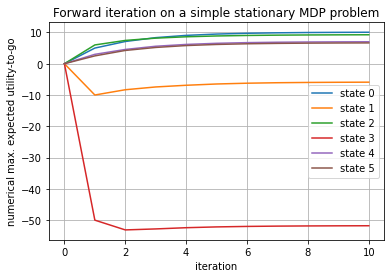

In [13]:
for state_idx in range(my_prob.get_num_states()):
    plt.plot(my_prob.val_table[:,state_idx],label=f'state {state_idx}')
plt.legend()
plt.grid('major')
plt.ylabel('numerical max. expected utility-to-go')
plt.xlabel('iteration')
plt.title("Forward value iteration on a simple stationary MDP problem")
plt.show()

## simulate the optimal policy (stochastically)

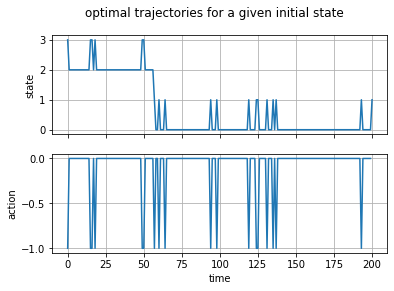

In [14]:
_, axs = plt.subplots(2,1,sharex=True)
N_sim = 200
X, U = my_prob.calc_traj(initial_state_idx=3, sim_steps=N_sim, seed =12545) # try other initial states
axs[0].plot(range(N_sim+1), X)
axs[1].plot(range(N_sim), U)
plt.suptitle('optimal trajectories for a given initial state')
axs[0].grid('major')
axs[1].grid('major')
axs[0].set_ylabel('state')
axs[1].set_ylabel('action')
axs[1].set_xlabel('time')
plt.show()